In [7]:
import numpy as np
import pandas as pd

import rasterio as rio
import xarray as xr
import rioxarray as rxr

from IPython.display import display
from matplotlib import pyplot

In [2]:
QA_BIT = {'fill': 0,
'dilated cloud': 1,
'cirrus': 2,
'cloud':3,
'cloud shadow':4,
'snow':5,
'clear': 6,
'water': 7,
'cloud confidence l': 8,
'cloud confidence h': 9,
'cloud shadow confidence l': 10,
'cloud shadow confidence h': 11,
'snow/ice confidence l': 12,
'snow/ice confidence h': 13,
'cirrus confidence l': 14,
'cirrus confidence h': 15
}

def mask_landsat(qa_arr, mask_list=['fill', 'Cloud', 'Cloud Shadow', 'Cloud Confidence high', 'Cloud Confidence moderate', 'Cloud Shadow Confidence high']):
    # This function takes the Landsat QA array as input and exports the cloud mask array. 
    # The mask_list assigns the QA conditions you would like to mask.
    # The list accept QA_BIT keys: "fill" to "water"; and confidence with 'high', 'moderate', or 'low' (e.g., Cloud Confidence high)
    msk = np.zeros_like(qa_arr)#.astype(bool)
    mask_list = [x.lower() for x in mask_list]
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (qa_arr & 1 << QA_BIT[m]) > 0
        if m.endswith("high"):
            l_bit = m.replace("high", 'l')
            h_bit = m.replace("high", 'h')
            msk += ((qa_arr & (1 << QA_BIT[h_bit])) > 0) * ((qa_arr & (1 << QA_BIT[l_bit])) > 0)
        if m.endswith("moderate"):
            l_bit = m.replace("moderate", 'l')
            h_bit = m.replace("moderate", 'h')
            msk += ((qa_arr & (1 << QA_BIT[h_bit])) > 0) * ((qa_arr | (1 << QA_BIT[l_bit])) != qa_arr)
        if m.endswith("low"):
            l_bit = m.replace("low", 'l')
            h_bit = m.replace("low", 'h')
            msk += ((qa_arr | (1 << QA_BIT[h_bit])) != qa_arr) * ((qa_arr & (1 << QA_BIT[l_bit])) > 0)
    return msk > 0

In [3]:
print("Cloud Shadow Confidence high".endswith("low"))
print("Cloud Shadow Confidence high".endswith("high"))
print("Cloud Shadow Confidence high".lower())

False
True
cloud shadow confidence high


,QA_value,cirrus confidence,snow/ice confidence,cloud shadow confidence,cloud confidence,water,clear,snow,cloud shadow,cloud,cirrus,dilated cloud,fill,Mask
0,1,00,00,00,00,0,0,0,0,0,0,0,1,True
1,21762,01,01,01,01,0,0,0,0,0,0,1,0,True
2,21824,01,01,01,01,0,1,0,0,0,0,0,0,False
3,21890,01,01,01,01,1,0,0,0,0,0,1,0,True
4,21952,01,01,01,01,1,1,0,0,0,0,0,0,False
5,22018,01,01,01,10,0,0,0,0,0,0,1,0,True
6,22080,01,01,01,10,0,1,0,0,0,0,0,0,True
7,22146,01,01,01,10,1,0,0,0,0,0,1,0,True
8,22208,01,01,01,10,1,1,0,0,0,0,0,0,True
9,22280,01,01,01,11,0,0,0,0,1,0,0,0,True


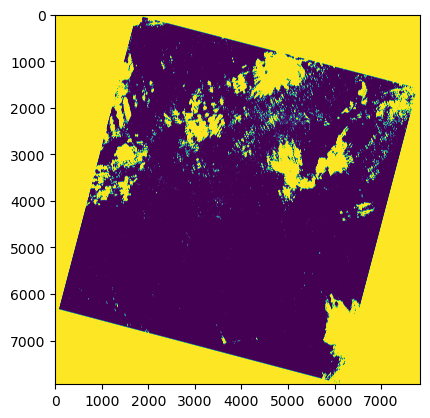

In [15]:
ras_path = r"C:\Users\qzhou2\C_workdir\QA2CloudMask\Landsat\LC09_L1TP_015033_20241105_20241105_02_T1_QA_PIXEL.TIF"

def QAstring2dict(qa: str):
    idx = -1
    qa_dict = {}
    for i, id in enumerate(list(QA_BIT.keys())[:8]):
        qa_dict[id] = qa[idx-i]
    qa_dict["cloud confidence"] = qa[6:8]
    qa_dict["cloud shadow confidence"] = qa[4:6]
    qa_dict["snow/ice confidence"] = qa[2:4]
    qa_dict["cirrus confidence"] = qa[0:2]
    return qa_dict

mask_list=['fill', 'Cloud', 'Cloud Shadow', 'dilated cloud', 'Cloud Confidence high', 'Cloud Confidence moderate', 'Cloud Shadow Confidence high']
with rxr.open_rasterio(ras_path) as ds:
    # print(ds)
    # ds.plot()

    ## unpack QA for inspection ##
    qa_unq = np.unique(ds)
    # for val in qa_unq:
    #     print('QA value and binary code:\t', val, '\t', "{0:016b}".format(val), 'Mask:\t', mask_landsat(np.asarray([val])))
    qa_df = pd.DataFrame([QAstring2dict("{0:016b}".format(q)) for q in qa_unq])
    qa_df["QA_value"] = qa_unq
    qa_df = qa_df.iloc[:, ::-1] # reverse the column order
    qa_df["Mask"] = mask_landsat(qa_unq, mask_list=mask_list)
    display(qa_df)

    ## Generate QA mask image ##
    arr_mask = mask_landsat(ds, mask_list=mask_list)
    pyplot.imshow(arr_mask.squeeze())
    pyplot.show()